<a name='0'></a>

# ConvMixer: Patches Are All You Need?

[ConvMixer](https://openreview.net/forum?id=TVHS5Y4dNvM) is an extremely simple architecture that directly operates on image patches like [Visual Transformers](https://arxiv.org/abs/2010.11929). The intent of the paper is to study if the extreme performance of Visual Transformers is due to inherent scaling behavior of transformers or if it is due to operating images patches as input representations!

What's in here:

* [1. Introduction](#1)
* [2. ConvMixer Architecture](#2)
* [3. ConvMixer-1536/20 Implementation](#3)
* [4. Final Notes](#4)
* [5. Reference Implementations](#5)

<a name='1'></a>
## 1. Introduction

Since the last decade(2010s) after a deep convolutional neural networks(ConvNets) AlexNet showed remarkable results on [ImageNet Challenge](https://arxiv.org/abs/2010.11929), convolutional neural networks became the go-to or dominant architecture in computer vision. 

But in the beginning of 2020s, visual transformers outperformed ConvNets on many visual tasks. The strong performance of transformers can be attributed to multi-head attentions layers but it's not clearly understood. The authors of ConvMixer suspect that the performance of transformers is due to using patch-based representations or simply put patches embeddings. Patches embedding means splitting images into multiple patches and combining them linearly. In visual transformers, the patches are directly applied to self-attentions.

To summarize: ConvMixer operates directly on patches just like visual transformers but instead of using attentions, it only uses standard convolutions. Also, ConvMixer maintains equal-resolution-and-size representations throughout all layers(means no downsampling at successive layers) and separate channel-wise mixing(using depthwise convolutions) from spatial mixing of information(using pointwise convolution or 1x1 convolution). 

Image below shows the comparison of accuracy of ConvMixer, [ResMLP](https://arxiv.org/abs/2105.03404), [DeiT](https://arxiv.org/abs/2012.12877), and [ResNet](https://arxiv.org/abs/1512.03385). The key takeaway from the graph is that ConvMixer achieves better accuracy than former networks with fewer parameters!



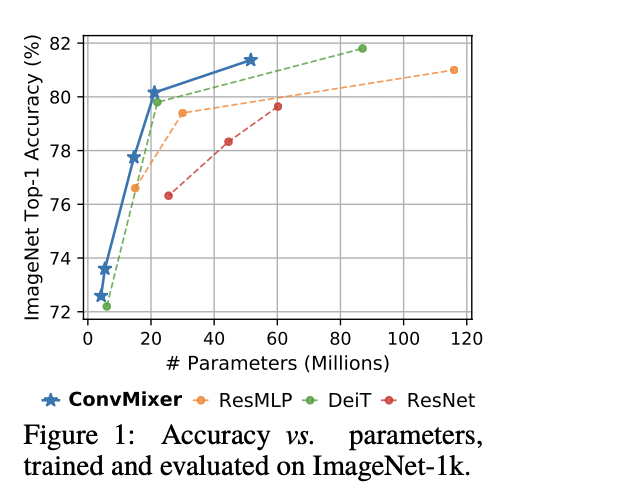


**Notes**: 

* [MLP-Mixer](https://arxiv.org/pdf/2105.01601.pdf) is one of the first architectures that tried to operate over image patches. MLP-Mixer is entirely based on multi-layer perceptrons(or MLPs, no convolutions or any attention layer) and is made of two main MLP layers - one that is applied independently on image patches(channel mixing) and other layer that is applied across patches(spatial mixing). MLP-Mixer also inspired ConvMixer name!!

* As also Luke Melas-Kyriazi showed in the paper prior to ConvMixer [Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet](https://arxiv.org/abs/2105.02723), it can be true that the strong performance of visual transformers are due to using patch-based representations. Luke replaced attention layer with feedforward layers and applied the resulting network to image patches. Looking on his results, it seems that patches-based representations largely contribute to the success of visual transformers given that replacing attentions with feedforward networks also achieved good results comparable to visual transformers!

* Recently, [ConvNeXt- ConvNets for 2020s](https://arxiv.org/pdf/2201.03545.pdf) modernized ResNets based on the design of visual transformers and the factors that contribute to superiority of transformers and showed that careful design of ConvNets can still achieve amazing results comparable to visual transformers. One of the similarities between ConvMixer and ConvNeXt is using patch-based input representations! We also summarized and implemented ConvNeXt - check it out [here](https://github.com/Nyandwi/ModernConvNets/blob/main/convnets/13-convnext.ipynb)!

<a name='2'></a>

## 2. ConvMixer Architecture

As we said, ConvMixer is a very simple and elegant architecture ever presented! Its official PyTorch implementation can be filled in a single tweet of 280 characters!!

```python
def ConvMixer(h,d,k,p,n):
 S,C,A=Sequential,Conv2d,lambda x:S(x,GELU(),BatchNorm2d(h))
 R=type('',(S,),{'forward':lambda s,x:s[0](x)+x})
 return S(A(C(3,h,p,p)),*[S(R(A(C(h,h,k,groups=h,padding=k//2))),A(C(h,h,1))) for i in range(d)],AdaptiveAvgPool2d(1),Flatten(),Linear(h,n))
 ```


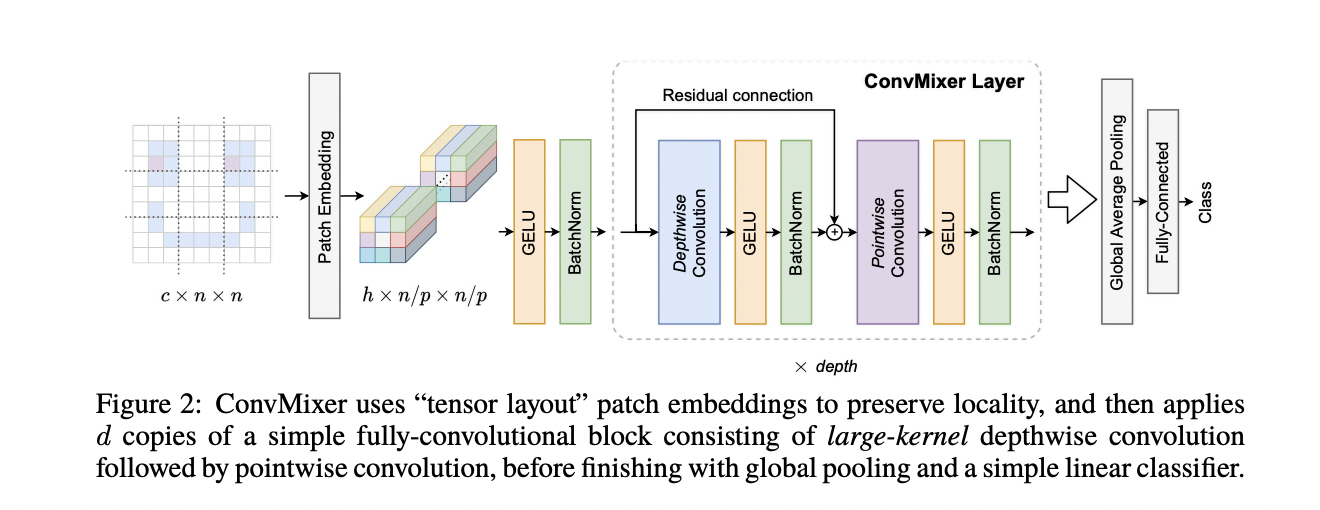

ConvMixer is made of 3 main parts:

* The first and most important part is a patch embedding layer that can be implemented with normal convolutional layer with input channels `ci`, output channels `h`, strides `s`, and kernel size `k`. All convolutions layers are followed by GELU non-linearity and batch normalization.

* The second important part is ConvMixer block that is made of depthwise convolutions(grouped convolution with groups equal to the number of channels) and pointwise convolutions(or 1x1 convolutions). ConvMixer block is repeated `depths` times. 

* The third part is classification head that contains global average pooling layer and fully connected layer with softmax activation.

ConvMixer block is made of four main parameters that are:

* The width or hidden dimension `h` or the dimensions or number of output channels in input convolution layer that produces patche embeddings.
* The depth `d` or number of ConvMixer blocks repeated across the network.
* The patch size `p` that controls the internal resolution(or the resolution of intermediate representations) of the model.
* The kernel size `k` in depthwise convolutions layer.

ConvMixer is named after the width `h` and depth `d`. In our implementation, we will implement ConvMixer-1536/20(1536 output channels in path-convolution layer and 20 repeated ConvMixer blocks or depth).

Finally, ConvMixer architecture is based on the idea of mixing (as is in [MLP-Mixer](https://arxiv.org/pdf/2105.01601.pdf)) - depthwise convolutions mix `spatial locations` and pointwise convolutions(or 1x1 conv) mix `channel locations`.

<a name='3'></a>

## 3. ConvMixer-1536/20 Implementation

We will implement `ConvMixer-1536/20` but other versions like `ConvMixer-768/32` and `ConvMixer-1024/20` can almost be implemented in similar ways. In ConvMixer-1536/20, 1536 stands for `width` or `hidded dimension` in the patches embedding layer and pointwise convolution and 20 stands for number of repeated ConvMixer blocks, or `depth`!

The following table depicts the configurations of ConvMixer-768/32 and ConvMixer-1536/20. ConvMixer-1024/20 does not appear on the table but it has kernel size of 9 and patch size of 14.

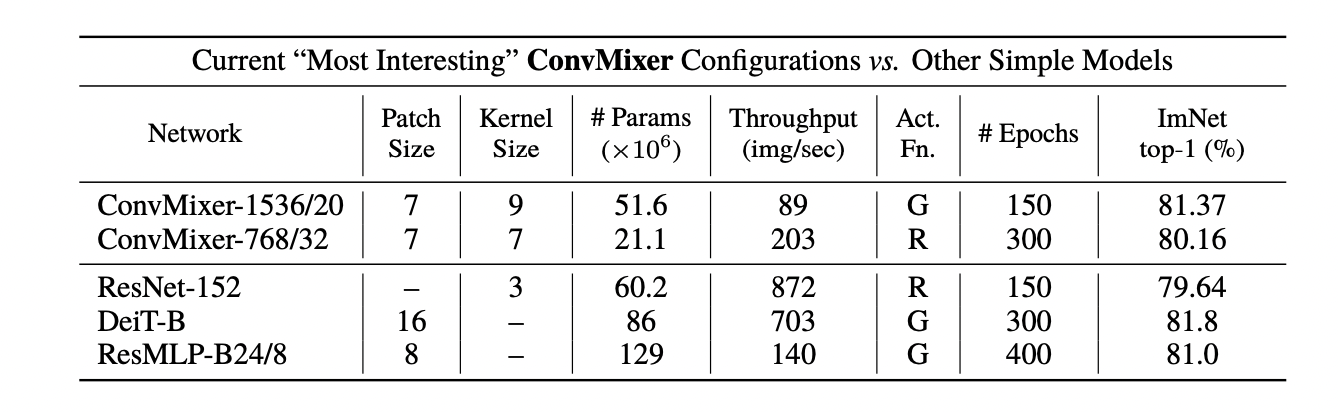

### Set Up

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

ConvMixer is a simple architecture. Our implementation should be simple too. Let's build a ConvMixer block and then put everything together!

### ConvMixer Block

In [ ]:
def convmixer_block(input, filters, kernel_size):
  """
  Input params
  ------
  input: input tensor
  filters: the number of output channels or filters in pointwise convolution
  kernel_size: kernel_size in depthwise convolution
  """
  shortcut = input

  # Depthwise convolution
  x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding='same')(input)
  x = keras.activations.gelu(x)
  x = layers.BatchNormalization()(x)

  # Shortcut connection
  x = layers.Add()([shortcut, x])

  # Pointwise or 1x1 convolution
  x = layers.Conv2D(filters=filters, kernel_size=1, padding='same')(x)
  x = keras.activations.gelu(x)
  x = layers.BatchNormalization()(x)

  return x

### Building the Whole Network

In [ ]:
# Defining some hyperparameters for ConvMixer-1536/20
input_shape = (224, 224, 3) 
patch_size = 7
depth = 20
kernel_size = 9
filters = 1536
num_classes = 1000 #per imagenet

# Input and patch embedding layer
input = layers.Input(input_shape)
x = layers.Conv2D(filters=filters, kernel_size=patch_size, strides=patch_size)(input)
x = keras.activations.gelu(x)
x = layers.BatchNormalization()(x)

# ConvMixer blocks repeated depth times
for _ in range(depth):
  x = convmixer_block(x, filters, kernel_size)

# Classification head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(units=num_classes, activation='softmax')(x)

convmixer = keras.Model(inputs=input, outputs=x)

In [ ]:
convmixer.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_42 (Conv2D)             (None, 32, 32, 1536  227328      ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 tf.nn.gelu_82 (TFOpLambda)     (None, 32, 32, 1536  0           ['conv2d_42[0][0]']              
                                )                                                           

The official implementation has 51.6M parameters. Ours has 51.6M trainable parameters too and 51.7M total parameters. It's pretty close!

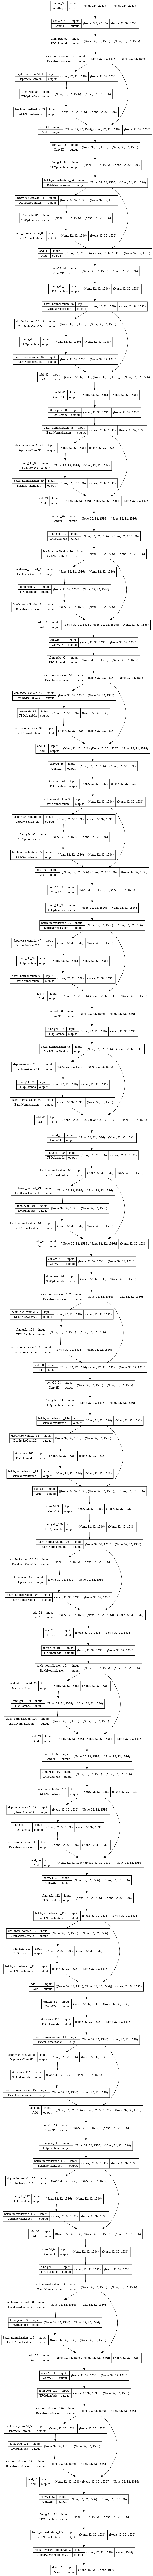

In [ ]:
plot_model(convmixer, show_shapes=True)

<a name='4'></a>

## 4. Final Notes

ConvMixer is an elegant architecture that attracted almost everyone in machine learning community([this](https://twitter.com/karpathy/status/1445915220644229124?s=20&t=RSF0xrG9Sg3Pvz0Uj8_cCQ) for example) and one of the first ever architecture that can fit in a tweet of 280 characters while achieving reasonable performance on ImageNet with little hyperparameter tuning(as reported in paper).

ConvMixer exploited the patch embeddings in standard convolutions and showed that the extreme performance of transformers is not only due to its inherent performance but also due to using patches-based input representations! As we also have seen, many other networks(like ResMLP and MLP-Mixer)!

<a name='5'></a>

## 5. References and Further Learning

* [ConvMixer - Patches are all you need paper](https://openreview.net/forum?id=TVHS5Y4dNvM)
* [ConvMixer official implementation](https://github.com/locuslab/convmixer)

### [BACK TOP](#0)